# 26.11.2024

## Introduction

In the previous prediction model, we used the sleepedf trained sleep stage model to predict the sleep stage of the UZH dataset. However, because each epoch for the UZH dataset is 20 second, and the sensor frequency is 125 Hz, the sleep stage prediction model is not suitable for the UZH dataset. In this notebook, we will cut out 30-second epochs from the UZH dataset then desample it to 100 Hz to match the sleepedf dataset. We will then use the sleepedf trained sleep stage model to predict the sleep stage of the UZH dataset.



In [2]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import os


In [3]:
# Data folder

data_folder = "/home/gs/code/tinysleepnet-pytorch-gs/data/EEG-SleepStaging_hdEEG"

# Load the .mat file
data = loadmat(data_folder + '/Filtered_EPISL_01_W1_EEG_FiltDwn_05to30Hz.mat')



In [4]:
# EEG data from the .mat file, shape = (129, 3605508)
eeg = data["EEG_filtered"]["EEG"][0, 0]

# Channel location
channel_location = data["EEG_filtered"]["chanlocs"][0, 0]

# Indices of clean epochs. Adjusted to 0-based indexing.
visgood = data["EEG_filtered"]["visgood"][0, 0] - 1

# Expert labeled sleep stages
visnum = data["EEG_filtered"]["visnum"][0, 0]

visgood = visgood.astype(int)
visnum = visnum.astype(int)


In [16]:
# FpZ was the 15th channel in the original data
eeg_fpz = eeg[14, :]
eeg_fpz.shape

(3605508,)

In [5]:
eeg_cz = eeg[128, :]
eeg_cz

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [7]:
# EEG signal frequency is 125 Hz
SIGNAL_FREQ = 125

# Each epoch is 20 seconds long
EPOCH_DURATION = 20


In [8]:
eeg_fpz_good = np.empty((0, 30 * SIGNAL_FREQ))
y_good = np.empty((0))
epoch_good = np.empty((0))

for i, epoch in np.ndenumerate(visgood[0]):

    print(i, epoch)

    next_epoch = epoch + 1

    if epoch in visgood[0] and next_epoch in visgood[0] and visnum[0, epoch] == visnum[0, next_epoch]:
        
        start = epoch * EPOCH_DURATION * SIGNAL_FREQ
        end = start + 30 * SIGNAL_FREQ
        eeg_fpz_good = np.concatenate((eeg_fpz_good, eeg_fpz[np.newaxis, start:end]), axis=0)
        y_good = np.concatenate((y_good, visnum[0, epoch][np.newaxis]), axis=0)
        epoch_good = np.concatenate((epoch_good, epoch[np.newaxis]), axis=0)





(0,) 2
(1,) 4
(2,) 5
(3,) 6
(4,) 7
(5,) 8
(6,) 10
(7,) 12
(8,) 18
(9,) 19
(10,) 20
(11,) 21
(12,) 22
(13,) 25
(14,) 26
(15,) 27
(16,) 28
(17,) 29
(18,) 30
(19,) 31
(20,) 32
(21,) 33
(22,) 34
(23,) 35
(24,) 36
(25,) 37
(26,) 38
(27,) 39
(28,) 40
(29,) 41
(30,) 42
(31,) 43
(32,) 44
(33,) 45
(34,) 46
(35,) 47
(36,) 48
(37,) 49
(38,) 50
(39,) 51
(40,) 52
(41,) 53
(42,) 54
(43,) 55
(44,) 56
(45,) 57
(46,) 58
(47,) 59
(48,) 60
(49,) 61
(50,) 62
(51,) 63
(52,) 64
(53,) 65
(54,) 66
(55,) 67
(56,) 68
(57,) 69
(58,) 70
(59,) 71
(60,) 72
(61,) 73
(62,) 74
(63,) 76
(64,) 77
(65,) 78
(66,) 79
(67,) 80
(68,) 81
(69,) 82
(70,) 83
(71,) 84
(72,) 85
(73,) 86
(74,) 87
(75,) 88
(76,) 89
(77,) 90
(78,) 91
(79,) 92
(80,) 93
(81,) 94
(82,) 95
(83,) 96
(84,) 97
(85,) 98
(86,) 99
(87,) 100
(88,) 101
(89,) 102
(90,) 103
(91,) 104
(92,) 105
(93,) 106
(94,) 107
(95,) 108
(96,) 109
(97,) 110
(98,) 111
(99,) 112
(100,) 113
(101,) 114
(102,) 115
(103,) 116
(104,) 117
(105,) 118
(106,) 119
(107,) 120
(108,) 121
(109

In [9]:
eeg_fpz_good, y_good, epoch_good

(array([[ -0.98857212,  -3.5708766 ,  -5.99488592, ...,  -2.33012843,
          -0.04385225,   1.03905928],
        [  2.43921971,   3.51365972,   5.12190819, ...,  -9.27447224,
          -8.93634224,  -6.77975178],
        [ -3.02678943,  -1.9129225 ,  -1.18222845, ...,   6.81698751,
           5.62546492,   5.88773012],
        ...,
        [  4.66662169,   6.5141716 ,   8.50525188, ...,  -2.24851346,
          -1.59953547,  -1.32690489],
        [  7.26324606,   1.05780888,  -4.6986742 , ...,  -8.09402466,
          -4.88014078,  -8.84194851],
        [ -1.99436188,  -7.48338747, -11.54912472, ...,  -0.93924844,
           1.39034176,   0.06425865]]),
 array([ 1.,  1.,  1., ..., -2., -2., -2.]),
 array([   4.,    5.,    6., ..., 1437., 1438., 1439.]))

In [10]:
# Adjust labels to Tinysleepnet format
# 0: Wake, 1: N1, 2: N2, 3: N3, 4: REM

y_good = y_good.astype(np.int32)

y_good = np.where(y_good == 1, 5, y_good)
y_good = np.where(y_good == 0, 9, y_good)
y_good = np.where(y_good == -1, 6, y_good)
y_good = np.where(y_good == -2, 7, y_good)
y_good = np.where(y_good == -3, 8, y_good)

y_good = y_good - 5
y_good

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

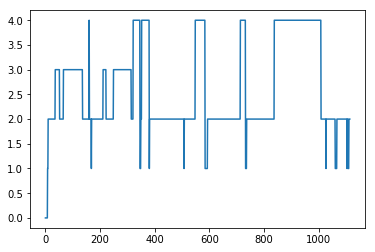

In [11]:
import matplotlib.pyplot as plt
plt.plot(y_good)

In [12]:
# Linearly interpolate each row to extend from 2500 to 3000 points.

import numpy as np
from scipy.interpolate import interp1d

# data_uzh = np.load("/home/gs/code/tinysleepnet-pytorch-gs/data/EEG-SleepStaging_hdEEG/output_channel15/Filtered_EPISL_01_W1_EEG_FiltDwn_05to30Hz.mat.npz")

data = eeg_fpz_good # Example data
print(data.shape)  # Output: (1114, 3750)


(1114, 3750)


In [ ]:

x_original = np.linspace(0, 1, 3750)
x_shrink = np.linspace(0, 1, 3000)

shrink_data = np.zeros((1114, 3000))

for i in range(data.shape[0]):
    interpolator = interp1d(x_original, data[i], kind='linear')
    shrink_data[i] = interpolator(x_shrink)

print(shrink_data.shape)  # Output: (1114, 3000)


NotImplementedError: fft is unsupported: Use fitpack routines for other types.

In [14]:
from scipy.signal import resample

# Resample the data
eeg_fpz_resampled = resample(eeg_fpz_good, 3000, axis=1)

print(eeg_fpz_resampled.shape)  # Output should be (n, 3000)

(1114, 3000)


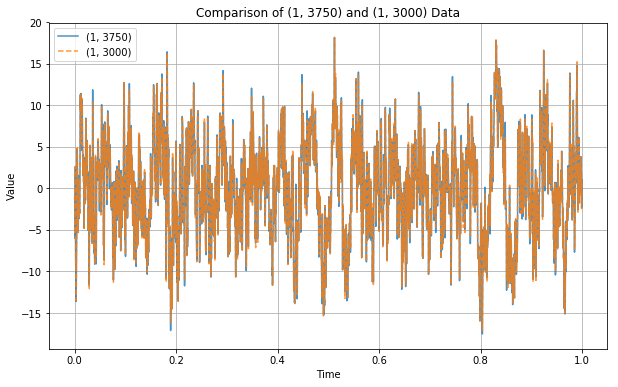

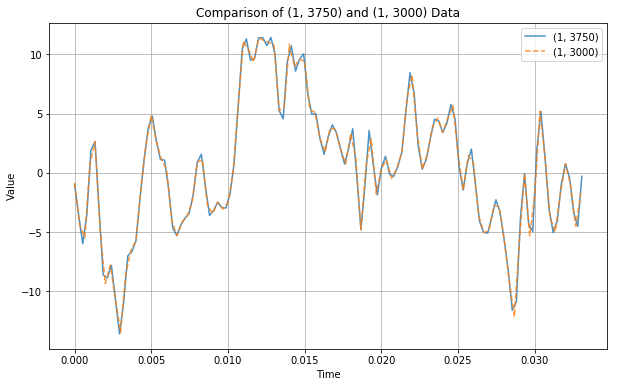

In [17]:

import matplotlib.pyplot as plt
import numpy as np

# Example data
data_3750 = eeg_fpz_good[0, :]
data_3000 = eeg_fpz_resampled[0, :]

# Create time indices
time_3750 = np.linspace(0, 1, 3750)
time_3000 = np.linspace(0, 1, 3000)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_3750, data_3750, label='(1, 3750)', alpha=0.8)
plt.plot(time_3000, data_3000, label='(1, 3000)', alpha=0.8, linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of (1, 3750) and (1, 3000) Data')
plt.legend()
plt.grid()
plt.show()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_3750[0:125], data_3750[0:125], label='(1, 3750)', alpha=0.8)
plt.plot(time_3000[0:100], data_3000[0:100], label='(1, 3000)', alpha=0.8, linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of (1, 3750) and (1, 3000) Data')
plt.legend()
plt.grid()
plt.show()

In [25]:
[
    "x",
    "y",
    "fs",
    "ch_label",
    "start_datetime",
    "file_duration",
    "epoch_duration",
    "n_all_epochs",
    "n_epochs",
]

x = shrink_data
y = y_good
fs = 100
ch_label = "Fpz"
start_datetime = "2021-01-01 00:00:00"
file_duration = eeg_fpz_good.shape[0] * EPOCH_DURATION
epoch_duration = eeg_fpz.shape[0] / SIGNAL_FREQ
n_all_epochs = visnum.shape[1]
n_epochs = eeg_fpz_good.shape[0]


In [26]:
np.savez("Filtered_EPISL_01_W1_EEG_Channel15_30s100hz", x=x, y=y, fs=fs, ch_label=ch_label, start_datetime=start_datetime, file_duration=file_duration, epoch_duration=epoch_duration, n_all_epochs=n_all_epochs, n_epochs=n_epochs)

In [27]:
from read_eeg_data_structure import read_eeg_data_structure

read_eeg_data_structure("/home/gs/code/tinysleepnet-pytorch-gs/notebook/uzh/Filtered_EPISL_01_W1_EEG_Channel15_30s100hz.npz")

x
(1114, 3000)
[[-0.98857212 -4.177081   -4.75375659 ... -2.12640146 -0.61561189
   1.03905928]
 [ 2.43921971  3.9158559   5.07648217 ... -8.29444595 -9.02090293
  -6.77975178]
 [-3.02678943 -1.73018808 -0.85378338 ...  8.4364126   5.92344489
   5.88773012]
 [-2.30066681  0.72559867  0.54921688 ...  5.29512863  8.07257283
   8.98645782]
 [ 4.1676569   2.48072335  2.8660951  ...  7.83883741  6.62395208
   4.93558645]]
y
(1114,)
[0 0 0 0 0]
fs 100
ch_label Fpz
start_datetime 2021-01-01 00:00:00
file_duration 22280
epoch_duration 28844.064
n_all_epochs 1442
n_epochs 1114
fs data type: int64


Prediction accuracy: 0.6678635547576302
{0: 0.0, 1: 0.03125, 2: 0.7990506329113924, 3: 1.0, 4: 0.2714285714285714}


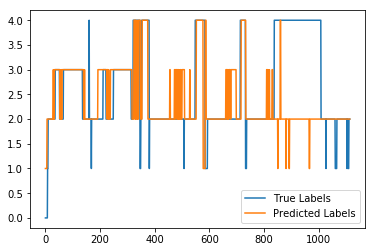

In [28]:
import numpy as np

predict_data = np.load("/home/gs/code/tinysleepnet-pytorch-gs/out_sleepedf/predict/pred_Filtered_EPISL_01_W1_EEG_Channel15_30s100hz_1.npz")

import matplotlib.pyplot as plt

plt.plot(predict_data["y_true"])
plt.plot(predict_data["y_pred"])
plt.legend(['True Labels', 'Predicted Labels'])

predict_accuracy = np.sum(predict_data["y_true"] == predict_data["y_pred"]) / len(predict_data["y_true"])

print(f"Prediction accuracy: {predict_accuracy}")

# Prediction accuracy at different sleep stages

y_true = predict_data["y_true"]
y_pred = predict_data["y_pred"]

accuracy_per_stage = {}
for stage in range(5):
    mask = y_true == stage
    accuracy_per_stage[stage] = np.sum(y_true[mask] == y_pred[mask]) / np.sum(mask)

print(accuracy_per_stage)

Prediction accuracy: 0.8105924596050269
{0: 0.0, 1: 0.0, 2: 0.9050632911392406, 3: 1.0, 4: 0.6035714285714285}


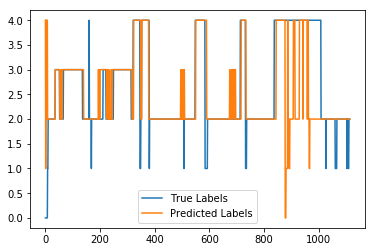

In [29]:
import numpy as np

predict_data = np.load("/home/gs/code/tinysleepnet-pytorch-gs/out_sleepedf/predict/pred_Filtered_EPISL_01_W1_EEG_Channel15_30s100hz_2.npz")

import matplotlib.pyplot as plt

plt.plot(predict_data["y_true"])
plt.plot(predict_data["y_pred"])
plt.legend(['True Labels', 'Predicted Labels'])

predict_accuracy = np.sum(predict_data["y_true"] == predict_data["y_pred"]) / len(predict_data["y_true"])

print(f"Prediction accuracy: {predict_accuracy}")

# Prediction accuracy at different sleep stages

y_true = predict_data["y_true"]
y_pred = predict_data["y_pred"]

accuracy_per_stage = {}
for stage in range(5):
    mask = y_true == stage
    accuracy_per_stage[stage] = np.sum(y_true[mask] == y_pred[mask]) / np.sum(mask)

print(accuracy_per_stage)

Prediction accuracy: 0.914721723518851
{0: 0.0, 1: 0.0, 2: 0.9699367088607594, 3: 0.9444444444444444, 4: 0.9035714285714286}


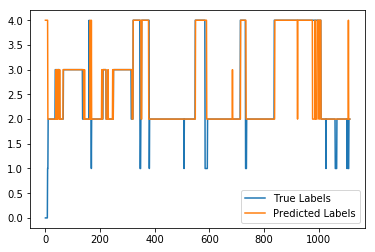

In [30]:
import numpy as np

predict_data = np.load("/home/gs/code/tinysleepnet-pytorch-gs/out_sleepedf/predict/pred_Filtered_EPISL_01_W1_EEG_Channel15_30s100hz_3.npz")

import matplotlib.pyplot as plt

plt.plot(predict_data["y_true"])
plt.plot(predict_data["y_pred"])
plt.legend(['True Labels', 'Predicted Labels'])

predict_accuracy = np.sum(predict_data["y_true"] == predict_data["y_pred"]) / len(predict_data["y_true"])

print(f"Prediction accuracy: {predict_accuracy}")

# Prediction accuracy at different sleep stages

y_true = predict_data["y_true"]
y_pred = predict_data["y_pred"]

accuracy_per_stage = {}
for stage in range(5):
    mask = y_true == stage
    accuracy_per_stage[stage] = np.sum(y_true[mask] == y_pred[mask]) / np.sum(mask)

print(accuracy_per_stage)

Prediction accuracy: 0.7926391382405745
{0: 0.75, 1: 0.03125, 2: 0.8544303797468354, 3: 1.0, 4: 0.6214285714285714}


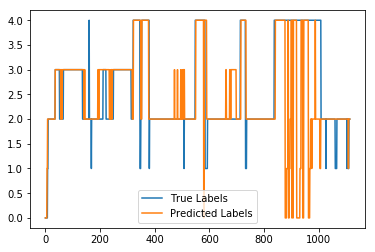

In [21]:
import numpy as np

predict_data = np.load("/home/gs/code/tinysleepnet-pytorch-gs/out_sleepedf/predict/pred_Filtered_EPISL_01_W1_EEG_Channel15_30s100hz_4.npz")

import matplotlib.pyplot as plt

plt.plot(predict_data["y_true"])
plt.plot(predict_data["y_pred"])
plt.legend(['True Labels', 'Predicted Labels'])

predict_accuracy = np.sum(predict_data["y_true"] == predict_data["y_pred"]) / len(predict_data["y_true"])

print(f"Prediction accuracy: {predict_accuracy}")

# Prediction accuracy at different sleep stages

y_true = predict_data["y_true"]
y_pred = predict_data["y_pred"]

accuracy_per_stage = {}
for stage in range(5):
    mask = y_true == stage
    accuracy_per_stage[stage] = np.sum(y_true[mask] == y_pred[mask]) / np.sum(mask)

print(accuracy_per_stage)

Prediction accuracy: 0.8025134649910234
{0: 1.0, 1: 0.1875, 2: 0.9572784810126582, 3: 0.9814814814814815, 4: 0.4142857142857143}


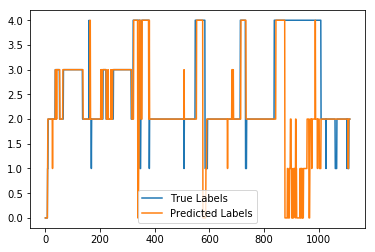

In [22]:
import numpy as np

predict_data = np.load("/home/gs/code/tinysleepnet-pytorch-gs/out_sleepedf/predict/pred_Filtered_EPISL_01_W1_EEG_Channel15_30s100hz_5.npz")

import matplotlib.pyplot as plt

plt.plot(predict_data["y_true"])
plt.plot(predict_data["y_pred"])
plt.legend(['True Labels', 'Predicted Labels'])

predict_accuracy = np.sum(predict_data["y_true"] == predict_data["y_pred"]) / len(predict_data["y_true"])

print(f"Prediction accuracy: {predict_accuracy}")

# Prediction accuracy at different sleep stages

y_true = predict_data["y_true"]
y_pred = predict_data["y_pred"]

accuracy_per_stage = {}
for stage in range(5):
    mask = y_true == stage
    accuracy_per_stage[stage] = np.sum(y_true[mask] == y_pred[mask]) / np.sum(mask)

print(accuracy_per_stage)

Prediction accuracy: 0.7989228007181328
{0: 0.0, 1: 0.0, 2: 0.8306962025316456, 3: 1.0, 4: 0.725}


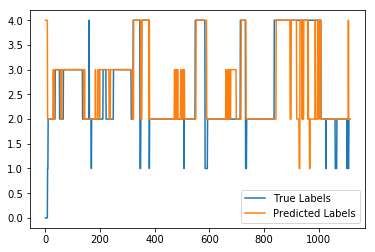

In [23]:
import numpy as np

predict_data = np.load("/home/gs/code/tinysleepnet-pytorch-gs/out_sleepedf/predict/pred_Filtered_EPISL_01_W1_EEG_Channel15_30s100hz_6.npz")

import matplotlib.pyplot as plt

plt.plot(predict_data["y_true"])
plt.plot(predict_data["y_pred"])
plt.legend(['True Labels', 'Predicted Labels'])

predict_accuracy = np.sum(predict_data["y_true"] == predict_data["y_pred"]) / len(predict_data["y_true"])

print(f"Prediction accuracy: {predict_accuracy}")

# Prediction accuracy at different sleep stages

y_true = predict_data["y_true"]
y_pred = predict_data["y_pred"]

accuracy_per_stage = {}
for stage in range(5):
    mask = y_true == stage
    accuracy_per_stage[stage] = np.sum(y_true[mask] == y_pred[mask]) / np.sum(mask)

print(accuracy_per_stage)

mat file:  Filtered_EPISL_03_W1_EEG_FiltDwn_05to30Hz.mat
(0,) 1
(1,) 2
(2,) 4
(3,) 5
(4,) 7
(5,) 8
(6,) 9
(7,) 10
(8,) 11
(9,) 13
(10,) 14
(11,) 15
(12,) 16
(13,) 17
(14,) 19
(15,) 20
(16,) 22
(17,) 23
(18,) 24
(19,) 25
(20,) 26
(21,) 28
(22,) 29
(23,) 30
(24,) 31
(25,) 32
(26,) 33
(27,) 34
(28,) 35
(29,) 36
(30,) 37
(31,) 38
(32,) 39
(33,) 40
(34,) 41
(35,) 42
(36,) 43
(37,) 44
(38,) 45
(39,) 46
(40,) 48
(41,) 49
(42,) 50
(43,) 51
(44,) 52
(45,) 53
(46,) 54
(47,) 55
(48,) 56
(49,) 58
(50,) 59
(51,) 60
(52,) 61
(53,) 62
(54,) 63
(55,) 64
(56,) 65
(57,) 66
(58,) 67
(59,) 68
(60,) 69
(61,) 71
(62,) 72
(63,) 73
(64,) 74
(65,) 75
(66,) 76
(67,) 77
(68,) 78
(69,) 79
(70,) 80
(71,) 81
(72,) 82
(73,) 84
(74,) 85
(75,) 86
(76,) 87
(77,) 88
(78,) 89
(79,) 90
(80,) 91
(81,) 92
(82,) 93
(83,) 94
(84,) 95
(85,) 96
(86,) 97
(87,) 98
(88,) 99
(89,) 100
(90,) 101
(91,) 102
(92,) 103
(93,) 104
(94,) 105
(95,) 106
(96,) 107
(97,) 108
(98,) 109
(99,) 110
(100,) 111
(101,) 112
(102,) 113
(103,) 114
(104,

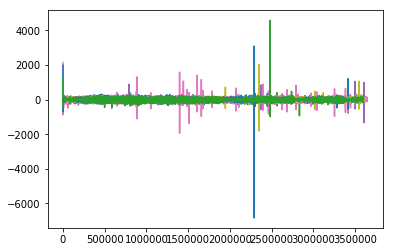

In [1]:
import importlib
import readin_mat_file

importlib.reload(readin_mat_file)


data_folder = "/home/gs/code/tinysleepnet-pytorch-gs/data/EEG-SleepStaging_hdEEG"

from readin_mat_file import readin_mat_file

readin_mat_file(data_folder)


In [20]:
output_folder = "/home/gs/code/tinysleepnet-pytorch-gs/out_sleepedf/predict"

import pandas as pd

results = pd.DataFrame(columns=["File", "Accuracy", "Stage0", "Stage1", "Stage2", "Stage3", "Stage4"])

for npz_file in os.listdir(output_folder):

    if npz_file.endswith(".npz") and "05to30Hz" in npz_file:

        predict_data = np.load(os.path.join(output_folder, npz_file))
        predict_accuracy = np.sum(predict_data["y_true"] == predict_data["y_pred"]) / len(predict_data["y_true"])

        print(f"Prediction accuracy for {npz_file}: {predict_accuracy}")

        y_true = predict_data["y_true"]
        y_pred = predict_data["y_pred"]

        accuracy_per_stage = {}

        for stage in range(5):

            mask = y_true == stage
            accuracy_per_stage[f"Stage{stage}"] = np.sum(y_true[mask] == y_pred[mask]) / np.sum(mask)

        print(f"Prediction accuracy at different sleep stages for {npz_file}: {accuracy_per_stage}")

        results = results.append({"File": npz_file, "Accuracy": predict_accuracy, **accuracy_per_stage}, ignore_index=True)

        results.to_csv("results_predict3.csv", index=False)

Prediction accuracy for pred_Filtered_EPISL_02_W1_EEG_FiltDwn_05to30Hz_2.npz: 0.74487895716946
Prediction accuracy at different sleep stages for pred_Filtered_EPISL_02_W1_EEG_FiltDwn_05to30Hz_2.npz: {'Stage0': 1.0, 'Stage1': 0.3076923076923077, 'Stage2': 0.9849137931034483, 'Stage3': 0.5876288659793815, 'Stage4': 0.28125}
Prediction accuracy for pred_Filtered_EPISL_05_W2_EEG_FiltDwn_05to30Hz_13.npz: 0.8189581554227157
Prediction accuracy at different sleep stages for pred_Filtered_EPISL_05_W2_EEG_FiltDwn_05to30Hz_13.npz: {'Stage0': 1.0, 'Stage1': 0.5, 'Stage2': 0.955456570155902, 'Stage3': 0.9685534591194969, 'Stage4': 0.5345744680851063}
Prediction accuracy for pred_Filtered_EPISL_02_W2_EEG_FiltDwn_05to30Hz_8.npz: 0.7118802619270346
Prediction accuracy at different sleep stages for pred_Filtered_EPISL_02_W2_EEG_FiltDwn_05to30Hz_8.npz: {'Stage0': 1.0, 'Stage1': 0.5, 'Stage2': 0.9604395604395605, 'Stage3': 0.7016393442622951, 'Stage4': 0.21888412017167383}
Prediction accuracy for pred_F

In [4]:
import os 
import numpy as np

output_folder = "/home/gs/code/tinysleepnet-pytorch-gs/out_sleepedf/predict"

import pandas as pd

results = pd.DataFrame(columns=["File", "Accuracy", "Stage0", "Stage1", "Stage2", "Stage3", "Stage4"])

for npz_file in os.listdir(output_folder):

    if npz_file.endswith(".npz") and "05to30Hz" in npz_file:

        predict_data = np.load(os.path.join(output_folder, npz_file))
        predict_accuracy = np.sum(predict_data["y_true"] == predict_data["y_pred"]) / len(predict_data["y_true"])

        print(f"Prediction accuracy for {npz_file}: {predict_accuracy}")

        y_true = predict_data["y_true"]
        y_pred = predict_data["y_pred"]

        accuracy_per_stage = {}

        for stage in range(5):

            mask = y_true == stage
            accuracy_per_stage[f"Stage{stage}"] = np.sum(y_true[mask] == y_pred[mask]) / np.sum(mask)

        print(f"Prediction accuracy at different sleep stages for {npz_file}: {accuracy_per_stage}")

        results = results.append({"File": npz_file, "Accuracy": predict_accuracy, **accuracy_per_stage}, ignore_index=True)

        results.to_csv("results_predict3_model2_21-40.csv", index=False)

Prediction accuracy for pred_Filtered_EPISL_06_W1_EEG_FiltDwn_05to30Hz_15.npz: 0.7490421455938697
Prediction accuracy at different sleep stages for pred_Filtered_EPISL_06_W1_EEG_FiltDwn_05to30Hz_15.npz: {'Stage0': 0.6491228070175439, 'Stage1': 0.1875, 'Stage2': 0.6152416356877324, 'Stage3': 0.9885714285714285, 'Stage4': 0.9224806201550387}
Prediction accuracy for pred_Filtered_EPISL_06_W2_EEG_FiltDwn_05to30Hz_11.npz: 0.9106498194945848
Prediction accuracy at different sleep stages for pred_Filtered_EPISL_06_W2_EEG_FiltDwn_05to30Hz_11.npz: {'Stage0': 0.35555555555555557, 'Stage1': 0.16666666666666666, 'Stage2': 0.9789103690685413, 'Stage3': 0.8604651162790697, 'Stage4': 0.9225806451612903}
Prediction accuracy for pred_Filtered_EPISL_06_W2_EEG_FiltDwn_05to30Hz_12.npz: 0.9106498194945848
Prediction accuracy at different sleep stages for pred_Filtered_EPISL_06_W2_EEG_FiltDwn_05to30Hz_12.npz: {'Stage0': 0.35555555555555557, 'Stage1': 0.16666666666666666, 'Stage2': 0.9789103690685413, 'Stage

In [32]:
d = np.load("/home/gs/code/tinysleepnet-pytorch-gs/out_sleepedf/predict/pred_Filtered_EPISL_01_W2_EEG_FiltDwn_05to30Hz_9.npz")

d.files

['y_true', 'y_pred']

In [ ]:
e = np.load("/home/gs/code/tinysleepnet-pytorch-gs/data/EEG-SleepStaging_hdEEG/uzh_fpz_chann15/Filtered_EPISL_01_W1_EEG_FiltDwn_05to30Hz_5.npz")

e.files


['x',
 'y',
 'fs',
 'ch_label',
 'start_datetime',
 'file_duration',
 'epoch_duration',
 'n_all_epochs',
 'n_epochs',
 'epoch_good',
 'visgood',
 'visnum']

In [36]:
e["epoch_good"], e["visgood"], e["visnum"]

(array([   4.,    5.,    6., ..., 1437., 1438., 1439.]),
 array([[   2,    4,    5, ..., 1439, 1440, 1441]], dtype=int32),
 array([[ 1,  1,  1, ..., -2, -2,  3]], dtype=int32))